In [1]:
import torchtext 
from torchtext import data
import torchtext.vocab as vocab

import torch
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import jieba
import jieba.analyse
import jieba.posseg
import random
import re
import os
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score


import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']

D:\ana\envs\pytorch1.7-py3.8\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Text_Classfier_Data():
    def __init__(self):
        self.path = os.path.abspath('.')
        self.df = pd.read_csv(os.path.join(self.path,'data\ChnSentiCorp_htl_all.csv'))
        self.df['review'] = self.df['review'].astype(str)
    def data_info(self):
        print(self.df.info())
    def distri_label(self):
        print(self.df['label'].value_counts())
    def clear_content(self):
#         pattern = r'''[!\"#$%&'()*+,-./:;<=>?@[\\\]^_`{|}~—！，。？·￥、《》···【】：" "''\s0-9]+'''
#         re_obj = re.compile(pattern)
        patten = r"[!\"#$%&'()*+,-./:;<=>?@[\\\]^_`{|}~—！，。？·￥、《》···【】：" "''\s0-9]+"  
        re_obj = re.compile(patten)

        # 替换函数--去除标点符号和数字
        def clear(text):
            return re_obj.sub('', text)

        # 将正则表达式替换函数应用于每一行
        self.df["review"] = self.df["review"].apply(clear)
#         self.df['review'] = self.df['review'].apply(lambda x:re_obj.sub('',x))
    def cut_sentence(self):
        self.df['review'] = self.df['review'].apply(lambda x:jieba.lcut(x))
    def remove_stoplist(self):
        stop_words = "data/stoplist.txt"
        stoplist = [i.strip() for i in open(stop_words, encoding='utf-8').readlines()]  #读取停用词列表
        self.df['review'] = self.df['review'].apply(lambda x:' '.join([word for word in x if word not in stoplist]))
    def get_text_vector(self,min_df,max_df,max_features):
        self.tfidf = TfidfVectorizer(min_df = min_df,max_df = max_df,max_features = max_features)
        self.tfidf.fit(self.df['review'])
        text = self.tfidf.transform(self.df['review'])
        return text
    def find_optimal_clusters(self,text,max_k):
        iters = range(2,max_k+1,2)
        sse = []
        for k in iters:
            km = MiniBatchKMeans(n_clusters = k,init_size = 1024,batch_size = 2048,random_state = 20).fit(text)
            sse.append(km.inertia_)
            print('Fit {} clusters'.format(k))
        f,ax = plt.subplots(1,1)
        ax.plot(iters,sse,marker = 'o')
        ax.set_xlabel('Cluster Centers')
        ax.set_xticks(iters)
        ax.set_xticklabels(iters)
        ax.set_ylabel('SSE')
        ax.set_title('SSE by Cluster Plot')
    def plot_tnse_pca(self,text,cluster):
        max_label = max(cluster)
        max_items = np.random.choice(range(text.shape[0]),size = 3000,replace = False)
        tdata = np.asarray(text[max_items,:].todense())
        pca = PCA(n_components = 2).fit_transform(tdata)
        tsne = TSNE().fit_transform(PCA(n_components = 50).fit_transform(tdata))
        
        
        idx = np.random.choice(range(pca.shape[0]),size = 300,replace = False)
        label_subset = cluster[max_items]
        label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
        
        
        f,ax = plt.subplots(1,2,figsize = (14,8))
        ax[0].scatter(pca[idx,0],pca[idx,1],c = label_subset)
        ax[0].set_title('PCA Cluster Plot')
        
        ax[1].scatter(tsne[idx,0],tsne[idx,1],c = label_subset)
        ax[1].set_title('TSNE Cluster Plot')
    def get_top_keywords(self,text,clusters,labels,n_terms):
        df = pd.DataFrame(text.todense()).groupby(clusters).mean()
        for i,r in df.iterrows():
            print('\n Cluster {}'.format(i))
            print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
    def replace_word(self,sentence):
        wordlist = []
        wordlist += [word.strip() for word in open('data/负面情感词语.txt',encoding = 'gbk').readlines()]
        wordlist += [word.strip() for word in open('data/负面评价词语.txt',encoding = 'gbk').readlines()]
        L = len(wordlist) - 1
        flag = 1
        sentence_tag = jieba.posseg.cut(sentence.strip())
        ans = ''
        for i,w in enumerate(sentence_tag):
            if w.flag != 'a':
                ans += w.word
            else:
                index = random.randint(1,L)
                ans += wordlist[index]
                ans += ''.join([w.word for j ,w in enumerate(sentence_tag) if j > i])
                flag = 0
                break
        if flag:
            ans += ''.join([w.word for w in sentence_tag])
            index = random.randint(1,L)
            ans += wordlist[index]
        return ans
    def get_balance_distri(self):
        df = self.df
        neg_df = df[df['label'] == 0].copy(deep = True)
        neg_df['review'] = neg_df['review'].apply(lambda x:self.replace_word(x))
        con_df = pd.concat([self.df,neg_df])
        return con_df
    def split_data(self,df,split = 8000):
        self.train_df,self.valid_df,self.test_df = df[:split],df[split:split + 1000],df[split+1000:]
    def store_data(self):
        self.train_df[['review','label']].to_csv('data/train.csv',index = False)
        self.valid_df[['review','label']].to_csv('data/valid.csv',index = False)
        self.test_df[['review','label']].to_csv('data/test.csv',index = False)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\m1824\AppData\Local\Temp\jieba.cache


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7766 entries, 0 to 7765
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   7766 non-null   int64 
 1   review  7766 non-null   object
dtypes: int64(1), object(1)
memory usage: 121.5+ KB
None
1    5322
0    2444
Name: label, dtype: int64


Loading model cost 2.099 seconds.
Prefix dict has been built successfully.


Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters

 Cluster 0
还会,环境,位置,下次,设施,房间,早餐,酒店,不错,服务

 Cluster 1
价格,干净,服务,房间,值得,不错,推荐,舒适,酒店,特别

 Cluster 2
干净,服务,早餐,环境,价格,总体,酒店,房间,感觉,不错

 Cluster 3
晚上,不好,携程,价格,设施,早餐,服务,酒店,宾馆,房间

 Cluster 4
感觉,年月日,服务员,客人,携程,前台,服务,房间,入住,酒店

------------new data distribution---------

1    5322
0    4888
Name: label, dtype: int64
finished


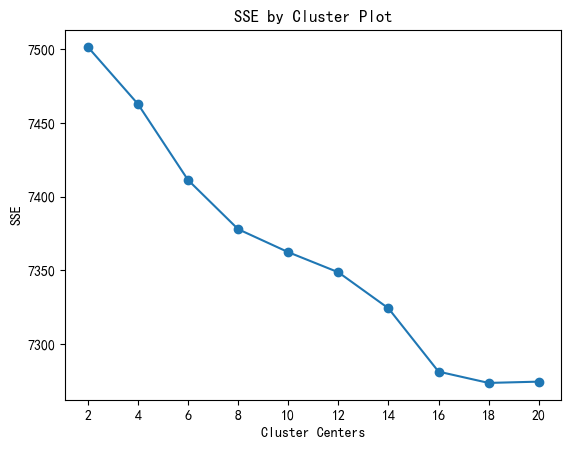

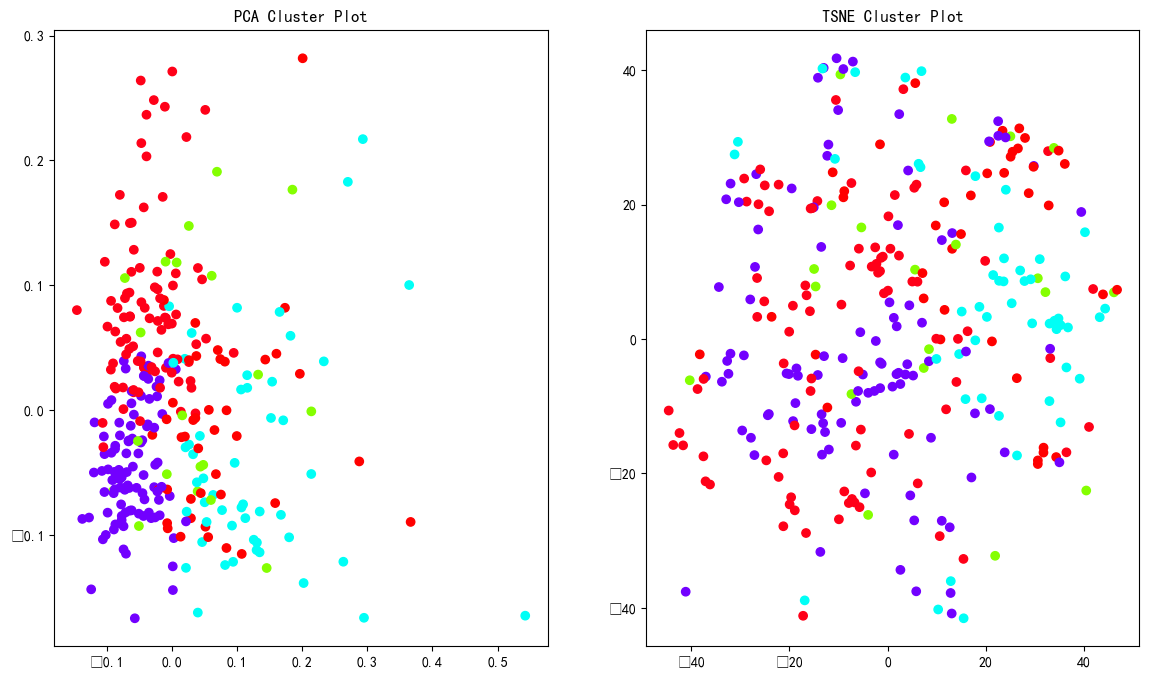

In [3]:
if __name__=='__main__':
    td = Text_Classfier_Data()
    td.data_info()
    td.distri_label()
    td.clear_content()
    td.cut_sentence()
    td.remove_stoplist()
    text = td.get_text_vector(5,0.95,8000)
    td.find_optimal_clusters(text,20)
    clusters = MiniBatchKMeans(n_clusters = 5,init_size = 1024,batch_size = 2048,random_state = 20).fit_predict(text)
    td.plot_tnse_pca(text,clusters)
    td.get_top_keywords(text,clusters,td.tfidf.get_feature_names_out(),10)
    km = MiniBatchKMeans(n_clusters = 5,init_size = 1024,batch_size = 1024,random_state = 20).fit(text)
    td.df['cluster'] = km.labels_
    td.df['label'].value_counts()
    td.df[td.df['label'] == 0].value_counts()
    con_df = td.get_balance_distri()
    print('\n------------new data distribution---------\n')
    print(con_df['label'].value_counts())
    td.split_data(con_df)
    td.store_data()
    print('finished')

In [10]:
wv_input = td.train_df['review'].apply(lambda s: s.split(" "))

In [12]:
from gensim import models

# Word2Vec
word2vec = models.Word2Vec(wv_input, 
                           vector_size=128,   # 词向量维度
                           min_count=1,      # 最小词频, 因为数据量较小, 这里卡1
                           epochs=50)      # 迭代轮次

In [13]:
word2vec.wv.most_similar("环境")

[('周围环境', 0.5383111834526062),
 ('环境优美', 0.47390052676200867),
 ('周边环境', 0.4624612033367157),
 ('空气', 0.4599194824695587),
 ('苏锡路', 0.42335957288742065),
 ('绿化', 0.4151880443096161),
 ('安静', 0.39823442697525024),
 ('优雅', 0.3950469493865967),
 ('景色', 0.39498916268348694),
 ('仪征市', 0.391552597284317)]

In [14]:
word2vec.wv.most_similar("不错")

[('挺不错', 0.5869125127792358),
 ('还行', 0.5220105051994324),
 ('比较满意', 0.5147444605827332),
 ('尚可', 0.5122641921043396),
 ('丰盛', 0.5047634243965149),
 ('行', 0.5042479634284973),
 ('物有所值', 0.4996906518936157),
 ('整洁', 0.4888794720172882),
 ('舒适', 0.48467013239860535),
 ('宽敞', 0.4841087758541107)]

In [15]:
word2vec.wv.most_similar("差")

[('很差', 0.6578645706176758),
 ('极差', 0.5927246809005737),
 ('太差', 0.5295570492744446),
 ('利害', 0.47320833802223206),
 ('不是太好', 0.46039310097694397),
 ('根据地', 0.4582006633281708),
 ('最差', 0.43891432881355286),
 ('糟糕', 0.43149158358573914),
 ('一般般', 0.4279016852378845),
 ('冷且', 0.422648549079895)]

In [16]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence,pad_packed_sequence
from torch.utils.data import Dataset, DataLoader

In [35]:
class Config():
    def __init__(self):
        self.learning_rate = 5e-4
        self.input_size = 768
        self.num_epoches = 5
        self.batch_size = 100
        self.embed_size = 128
        self.hidden_size = 64
        self.num_layers = 2
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
args = Config()

In [36]:
# 数据集
class MyDataset(Dataset):
    def __init__(self, df):
        self.data = []
        self.label = df["label"].tolist()
        for s in df["review"].tolist():
            vectors = []
            for w in s.split(" "):
                if w in word2vec.wv.key_to_index:
                    vectors.append(word2vec.wv[w])   # 将每个词替换为对应的词向量
            vectors = torch.Tensor(vectors)
            self.data.append(vectors)
    
    def __getitem__(self, index):
        data = self.data[index]
        label = self.label[index]
        return data, label

    def __len__(self):
        return len(self.label)

def collate_fn(data):
    """
    :param data: 第0维：data，第1维：label
    :return: 序列化的data、记录实际长度的序列、以及label列表
    """
    data.sort(key=lambda x: len(x[0]), reverse=True) # pack_padded_sequence要求要按照序列的长度倒序排列
    data_length = [len(sq[0]) for sq in data]
    x = [i[0] for i in data]
    y = [i[1] for i in data]
    data = pad_sequence(x, batch_first=True, padding_value=0)   # 用RNN处理变长序列的必要操作
    return data, torch.tensor(y, dtype=torch.float32), data_length

In [47]:
# 训练集
train_data = MyDataset(td.train_df[['review','label']])
train_loader = DataLoader(train_data, batch_size = args.batch_size, collate_fn = collate_fn, shuffle=True)

# 测试集
test_data = MyDataset(td.test_df[['review','label']])
test_loader = DataLoader(test_data, batch_size = args.batch_size, collate_fn = collate_fn, shuffle=True)

In [48]:
# 网络结构
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)  # 双向, 输出维度要*2
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(args.device)  # 双向, 第一个维度要*2
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(args.device)
        
        packed_input = torch.nn.utils.rnn.pack_padded_sequence(input=x, lengths=lengths, batch_first=True)
        packed_out, (h_n, h_c) = self.lstm(packed_input, (h0, c0))

        lstm_out = torch.cat([h_n[-2], h_n[-1]], 1)  # 双向, 所以要将最后两维拼接, 得到的就是最后一个time step的输出
        out = self.fc(lstm_out)
        out = self.sigmoid(out)
        return out

lstm = LSTM(args.embed_size, args.hidden_size, args.num_layers)

In [63]:
from sklearn import metrics

# 在测试集效果检验
def test():
    y_pred, y_true = [], []

    with torch.no_grad():
        for x, labels, lengths in test_loader:
            x = x.to(args.device)
            outputs = lstm(x, lengths)          # 前向传播
            outputs = outputs.view(-1)          # 将输出展平
            y_pred.append(outputs)
            y_true.append(labels)

    y_prob = torch.cat(y_pred)
    y_true = torch.cat(y_true)
    y_pred = y_prob.clone()
    y_pred[y_pred > 0.8] = 1
    y_pred[y_pred <= 0.8] = 0
    
    print(metrics.classification_report(y_true, y_pred))
    print("准确率:", metrics.accuracy_score(y_true, y_pred))
#     print("AUC:", metrics.roc_auc_score(y_true, y_prob) )

In [64]:
# 定义损失函数和优化器
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr = args.learning_rate)

In [65]:
# 迭代训练
for epoch in range(args.num_epoches):
    total_loss = 0
    cur_loss = float('inf')
    for i, (x, labels, lengths) in enumerate(train_loader):
        x = x.to(args.device)
        labels = labels.to(args.device)
        outputs = lstm(x, lengths)          # 前向传播
        logits = outputs.view(-1)           # 将输出展平
        loss = criterion(logits, labels)    # loss计算
        total_loss += loss
        optimizer.zero_grad()               # 梯度清零
        loss.backward(retain_graph=True)    # 反向传播，计算梯度
        optimizer.step()                    # 梯度更新
        if (i+1) % 10 == 0:
            print("epoch:{}, step:{}, loss:{}".format(epoch+1, i+1, total_loss/10))
            if cur_loss > total_loss:
                cur_loss = total_loss
                model_path = "./done_model/lstm_{}.model".format(epoch+1)
                torch.save(lstm, model_path)
            total_loss = 0
    
    # test
    test()
    
    # save model
    model_path = "./done_model/lstm_{}.model".format(epoch+1)
    torch.save(lstm, model_path)
    print("saved model: ", model_path)

epoch:1, step:10, loss:0.2399362325668335
epoch:1, step:20, loss:0.27584701776504517
epoch:1, step:30, loss:0.2625795304775238
epoch:1, step:40, loss:0.26666802167892456
epoch:1, step:50, loss:0.24614182114601135
epoch:1, step:60, loss:0.21568317711353302
epoch:1, step:70, loss:0.234961599111557
epoch:1, step:80, loss:0.2480115443468094
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.97      1210
         1.0       0.00      0.00      0.00         0

    accuracy                           0.93      1210
   macro avg       0.50      0.47      0.48      1210
weighted avg       1.00      0.93      0.97      1210

准确率: 0.9347107438016529
saved model:  ./done_model/lstm_1.model
epoch:2, step:10, loss:0.21661797165870667
epoch:2, step:20, loss:0.2099345475435257
epoch:2, step:30, loss:0.23061637580394745
epoch:2, step:40, loss:0.2226143181324005
epoch:2, step:50, loss:0.30674654245376587
epoch:2, step:60, loss:0.3057806193828583
epoch:2, step:7

In [71]:
net = torch.load("./done_model/lstm_3.model")    # 训练过程中的表现最好

In [84]:
def processing(text):
    """
    数据预处理, 可以根据自己的需求进行重载
    """
    # 数据清洗部分
    text = re.sub("\{%.+?%\}", " ", text)           # 去除 {%xxx%} (地理定位, 微博话题等)
    text = re.sub("@.+?( |$)", " ", text)           # 去除 @xxx (用户名)
    text = re.sub("【.+?】", " ", text)              # 去除 【xx】 (里面的内容通常都不是用户自己写的)
    text = re.sub("\u200b", " ", text)              # '\u200b'是这个数据集中的一个bad case, 不用特别在意
    # 分词
    words = [w for w in jieba.lcut(text) if w.isalpha()]
    # 对否定词`不`做特殊处理: 与其后面的词进行拼接
    while "不" in words:
        index = words.index("不")
        if index == len(words) - 1:
            break
        words[index: index+2] = ["".join(words[index: index+2])]  # 列表切片赋值的酷炫写法
    # 用空格拼接成字符串
    result = " ".join(words)
    return result

In [88]:
strs = ["这酒店服务也太香咯，下次还去", "房价环境极差"]

data = []
for s in strs:
    vectors = []
    for w in processing(s).split(" "):
        if w in word2vec.wv.key_to_index:
            vectors.append(word2vec.wv[w])   # 将每个词替换为对应的词向量
    vectors = torch.Tensor(vectors)
    data.append(vectors)
x, _, lengths = collate_fn(list(zip(data, [-1] * len(strs))))
with torch.no_grad():
    x = x.to(args.device)
    outputs = lstm(x, lengths)          # 前向传播
    outputs = outputs.view(-1)          # 将输出展平
outputs

tensor([0.6747, 0.1500])